In [1]:
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import random
import torch
import numpy as np
import seaborn as sns

from data_analysis_preparation.utils import filter_df_by_problem
from dataloader import Mri3DDataLoader
from model import MRINet
from training_loop import evaluate_model, run_training_loop


Using device: mps


### Reproducibility

In [2]:
torch.manual_seed(2**30) 
random.seed(2**30)
np.random.seed(2**30)

### Load data

In [3]:
TRAIN_DATA_PATH = "/Users/michaelhase/Desktop/SeniorThesis/data/tabular_data/train_base.csv"
TEST_DATA_PATH = "/Users/michaelhase/Desktop/SeniorThesis/data/tabular_data/test_base.csv"
VALID_DATA_PATH = "/Users/michaelhase/Desktop/SeniorThesis/data/tabular_data/val_base.csv"

MODEL_SAVE_DIRECTORY = "/Users/michaelhase/Desktop/SeniorThesis/models"

In [4]:
train_df = pd.read_csv(TRAIN_DATA_PATH)
test_df = pd.read_csv(TEST_DATA_PATH)
valid_df = pd.read_csv(VALID_DATA_PATH)
num_epochs = 10

### Training and evaluation process

In [5]:
def plot_confusion_matrix(results: dict, problem: str, dataset: str) -> None:
    columns = problems[problem]
    cf_matrix = results[problem][dataset]["confusion_matrix"]
    s = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,
                    fmt='.2%', cmap='Blues', xticklabels=columns,
                    yticklabels=columns)
    s.set_xlabel("Predicted label")
    s.set_ylabel("True label")

In [6]:
problems = {"AD vs CN": ["AD", "CN"] , "AD vs MCI": ["AD", "MCI"], "MCI vs CN": ["MCI", "CN"], "AD vs MCI vs CN": ["MCI", "CN", "AD"], "p-MCI vs np-MCI": ["p-MCI", "np-MCI"]}
batch_size = 4


In [7]:
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
# Define learning rate and scheduler parameters
initial_lr = 1e-3
step_size = 3
gamma = 0.1

histories = {}
results = {problem: {} for problem in problems}

for problem, columns in problems.items():
    print(f"Training {problem}")
    
    # Load datasets
    _train_df = Mri3DDataLoader(filter_df_by_problem(problem, train_df), classification_values=columns,
                                batch_size=batch_size, crop=False)
    _test_df = Mri3DDataLoader(filter_df_by_problem(problem, test_df), classification_values=columns,
                               batch_size=batch_size, crop=False)
    _valid_df = Mri3DDataLoader(filter_df_by_problem(problem, valid_df), classification_values=columns,
                                batch_size=batch_size, crop=False)

    save_directory = Path(MODEL_SAVE_DIRECTORY, problem)
    
    # Initialize model with appropriate number of classes
    num_classes = 2 if problem != "AD vs MCI vs CN" else 3
    model = MRINet(num_classes=num_classes).to("mps")  # Ensure model is on MPS device
    
    # Load pretrained model, excluding incompatible layers
    state_dict = torch.load(r"/Users/michaelhase/Desktop/SeniorThesis/imaging_models/models/pretrained/best_model.pth")
    state_dict.pop('classifier.2.weight', None)
    state_dict.pop('classifier.2.bias', None)
    model.load_state_dict(state_dict, strict=False)
    
    # Define optimizer and scheduler
    optimizer = Adam(model.parameters(), lr=initial_lr)
    scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)
    
    # Train model with scheduler and from_pretrained flag
    history = run_training_loop(
        model=model,
        train_dataset=_train_df,
        valid_dataset=_valid_df,
        num_epochs=num_epochs,
        optimizer=optimizer,
        batch_size=batch_size,
        save_directory=save_directory,
        from_pretrained=True,
        scheduler=scheduler
    )
    
    # Save training history
    histories[problem] = history
    
    # Load best model for evaluation
    model.load_state_dict(torch.load(Path(save_directory, "best_model.pth")))
    
    # Evaluate model on train, test, and validation datasets
    results[problem] = {
        "train": evaluate_model(model, _train_df),
        "test": evaluate_model(model, _test_df),
        "valid": evaluate_model(model, _valid_df)
    }
    print(f"Results for {problem}: {results[problem]}")

Training AD vs CN


/var/folders/16/v2y5n0097wvcclskn_5f_8hm0000gn/T/ipykernel_2025/2480218455.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(r"/Users/michaelhase/

Freezing all layers except the last fully connected layer.


  0%|          | 0/66 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/pooling.py:733: UserWarning: The operator 'aten::avg_pool3d.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)
  return F.avg_pool3d(input, self.kernel_size, self.stride,
Epoch: 0, LR: [0.001] Step loss: 0.621, Step acc: 2.0, Train Accuracy: 0.523, Balanced Accuracy: 0.513, Running Loss: 0.838: 100%|██████████| 66/66 [00:39<00:00,  1.68it/s]
Validation Loss - item: 0.787, Validation Accuracy: 0.531, Balanced accuracy: 0.531, Running Loss: 0.721: 100%|██████████| 8/8 [00:04<00:00,  1.99it/s]



Best validation accuracy: 0.53125
Saving best model for epoch: 1

Unfreezing all layers.


Epoch: 1, LR: [0.001] Step loss: 1.34, Step acc: 1.0, Train Accuracy: 0.538, Balanced Accuracy: 0.527, Running Loss: 0.858: 100%|██████████| 66/66 [03:33<00:00,  3.23s/it] 
Validation Loss - item: 0.858, Validation Accuracy: 0.469, Balanced accuracy: 0.5, Running Loss: 0.736: 100%|██████████| 8/8 [00:03<00:00,  2.08it/s]
  0%|          | 0/66 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2466: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
Epoch: 2, LR: [0.001] Step loss: 0.522, Step acc: 3.0, Train Accuracy: 0.553, Balanced Accuracy: 0.552, Running Loss: 0.742: 100%|██████████| 66/66 [03:30<00:00,  3.18s/it]
Validation Loss - item: 0.659, Validation Accuracy: 0.469, Balanced accuracy: 0.461, Running Loss: 0.708: 100%|██████████| 8/8 [00:03<00:00,  2.08it/s]
Epoch: 3, LR: [0.0001] Step loss: 0.686, Step acc: 2.0, Train Accuracy: 0.595, Balanc


Best validation accuracy: 0.5317460317460317
Saving best model for epoch: 4



Epoch: 4, LR: [0.0001] Step loss: 0.886, Step acc: 1.0, Train Accuracy: 0.561, Balanced Accuracy: 0.561, Running Loss: 0.695: 100%|██████████| 66/66 [03:30<00:00,  3.20s/it]
Validation Loss - item: 0.523, Validation Accuracy: 0.562, Balanced accuracy: 0.541, Running Loss: 0.703: 100%|██████████| 8/8 [00:03<00:00,  2.04it/s]



Best validation accuracy: 0.5411764705882353
Saving best model for epoch: 5



Epoch: 5, LR: [0.0001] Step loss: 0.609, Step acc: 3.0, Train Accuracy: 0.617, Balanced Accuracy: 0.604, Running Loss: 0.675: 100%|██████████| 66/66 [03:34<00:00,  3.25s/it]
Validation Loss - item: 0.856, Validation Accuracy: 0.531, Balanced accuracy: 0.531, Running Loss: 0.679: 100%|██████████| 8/8 [00:03<00:00,  2.04it/s]
Epoch: 6, LR: [1e-05] Step loss: 0.696, Step acc: 3.0, Train Accuracy: 0.64, Balanced Accuracy: 0.633, Running Loss: 0.657: 100%|██████████| 66/66 [03:35<00:00,  3.26s/it] 
Validation Loss - item: 0.856, Validation Accuracy: 0.469, Balanced accuracy: 0.457, Running Loss: 0.69: 100%|██████████| 8/8 [00:03<00:00,  2.04it/s] 
Epoch: 7, LR: [1e-05] Step loss: 0.581, Step acc: 2.0, Train Accuracy: 0.644, Balanced Accuracy: 0.635, Running Loss: 0.64: 100%|██████████| 66/66 [36:23<00:00, 33.09s/it]    
Validation Loss - item: 0.767, Validation Accuracy: 0.531, Balanced accuracy: 0.516, Running Loss: 0.69: 100%|██████████| 8/8 [00:03<00:00,  2.08it/s] 
Epoch: 8, LR: [1e-05]

Results for AD vs CN: {'train': {'accuracy': 0.6477272727272727, 'balanced_accuracy': 0.6188811188811189, 'roc_auc': 0.6188811188811189, 'roc_curve': (array([0.        , 0.72727273, 1.        ]), array([0.        , 0.96503497, 1.        ]), array([inf,  1.,  0.])), 'confusion_matrix': array([[ 33,  88],
       [  5, 138]])}, 'test': {'accuracy': 0.53125, 'balanced_accuracy': 0.49603174603174605, 'roc_auc': 0.49603174603174605, 'roc_curve': (array([0.        , 0.78571429, 1.        ]), array([0.        , 0.77777778, 1.        ]), array([inf,  1.,  0.])), 'confusion_matrix': array([[ 3, 11],
       [ 4, 14]])}, 'valid': {'accuracy': 0.59375, 'balanced_accuracy': 0.5515873015873015, 'roc_auc': 0.5515873015873016, 'roc_curve': (array([0.        , 0.78571429, 1.        ]), array([0.        , 0.88888889, 1.        ]), array([inf,  1.,  0.])), 'confusion_matrix': array([[ 3, 11],
       [ 2, 16]])}}
Training AD vs MCI
Freezing all layers except the last fully connected layer.


Epoch: 0, LR: [0.001] Step loss: 0.455, Step acc: 3.0, Train Accuracy: 0.667, Balanced Accuracy: 0.488, Running Loss: 0.688: 100%|██████████| 114/114 [01:01<00:00,  1.87it/s]
Validation Loss - item: 0.546, Validation Accuracy: 0.714, Balanced accuracy: 0.5, Running Loss: 0.607: 100%|██████████| 14/14 [00:06<00:00,  2.07it/s]



Best validation accuracy: 0.5
Saving best model for epoch: 1

Unfreezing all layers.


  0%|          | 0/114 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:395: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
Epoch: 1, LR: [0.001] Step loss: 0.854, Step acc: 2.0, Train Accuracy: 0.678, Balanced Accuracy: 0.524, Running Loss: 0.702: 100%|██████████| 114/114 [06:11<00:00,  3.26s/it]
Validation Loss - item: 0.571, Validation Accuracy: 0.714, Balanced accuracy: 0.5, Running Loss: 0.665: 100%|██████████| 14/14 [00:06<00:00,  2.13it/s]
  0%|          | 0/114 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:395: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.


Results for AD vs MCI: {'train': {'accuracy': 0.7346491228070176, 'balanced_accuracy': 0.5, 'roc_auc': 0.5, 'roc_curve': (array([0., 1.]), array([0., 1.]), array([inf,  1.])), 'confusion_matrix': array([[  0, 121],
       [  0, 335]])}, 'test': {'accuracy': 0.7678571428571429, 'balanced_accuracy': 0.5, 'roc_auc': 0.5, 'roc_curve': (array([0., 1.]), array([0., 1.]), array([inf,  1.])), 'confusion_matrix': array([[ 0, 13],
       [ 0, 43]])}, 'valid': {'accuracy': 0.7321428571428571, 'balanced_accuracy': 0.5, 'roc_auc': 0.5, 'roc_curve': (array([0., 1.]), array([0., 1.]), array([inf,  1.])), 'confusion_matrix': array([[ 0, 15],
       [ 0, 41]])}}
Training MCI vs CN
Freezing all layers except the last fully connected layer.


Epoch: 0, LR: [0.001] Step loss: 0.303, Step acc: 4.0, Train Accuracy: 0.627, Balanced Accuracy: 0.505, Running Loss: 0.747: 100%|██████████| 120/120 [01:03<00:00,  1.90it/s]
Validation Loss - item: 0.549, Validation Accuracy: 0.696, Balanced accuracy: 0.5, Running Loss: 0.684: 100%|██████████| 14/14 [00:06<00:00,  2.06it/s]



Best validation accuracy: 0.5
Saving best model for epoch: 1

Unfreezing all layers.


Epoch: 1, LR: [0.001] Step loss: 0.593, Step acc: 3.0, Train Accuracy: 0.654, Balanced Accuracy: 0.538, Running Loss: 0.717: 100%|██████████| 120/120 [06:16<00:00,  3.14s/it]
Validation Loss - item: 0.237, Validation Accuracy: 0.696, Balanced accuracy: 0.5, Running Loss: 0.636: 100%|██████████| 14/14 [00:06<00:00,  2.07it/s]
Epoch: 2, LR: [0.001] Step loss: 0.881, Step acc: 2.0, Train Accuracy: 0.665, Balanced Accuracy: 0.522, Running Loss: 0.669: 100%|██████████| 120/120 [06:14<00:00,  3.12s/it]
Validation Loss - item: 0.513, Validation Accuracy: 0.696, Balanced accuracy: 0.5, Running Loss: 0.74: 100%|██████████| 14/14 [00:06<00:00,  2.07it/s] 
  0%|          | 0/120 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:395: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
E


Best validation accuracy: 0.5277777777777778
Saving best model for epoch: 9



Epoch: 9, LR: [1.0000000000000002e-06] Step loss: 0.658, Step acc: 2.0, Train Accuracy: 0.692, Balanced Accuracy: 0.52, Running Loss: 0.584: 100%|██████████| 120/120 [06:12<00:00,  3.10s/it] 
  0%|          | 0/14 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:395: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
Validation Loss - item: 0.449, Validation Accuracy: 0.696, Balanced accuracy: 0.5, Running Loss: 0.569: 100%|██████████| 14/14 [00:06<00:00,  2.09it/s]
/var/folders/16/v2y5n0097wvcclskn_5f_8hm0000gn/T/ipykernel_2025/2480218455.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code 

Results for MCI vs CN: {'train': {'accuracy': 0.7145833333333333, 'balanced_accuracy': 0.5262896825396826, 'roc_auc': 0.5262896825396826, 'roc_curve': (array([0.        , 0.00297619, 1.        ]), array([0.        , 0.05555556, 1.        ]), array([inf,  1.,  0.])), 'confusion_matrix': array([[335,   1],
       [136,   8]])}, 'test': {'accuracy': 0.7333333333333333, 'balanced_accuracy': 0.5, 'roc_auc': 0.5, 'roc_curve': (array([0., 1.]), array([0., 1.]), array([inf,  0.])), 'confusion_matrix': array([[44,  0],
       [16,  0]])}, 'valid': {'accuracy': 0.7142857142857143, 'balanced_accuracy': 0.5294117647058824, 'roc_auc': 0.5294117647058824, 'roc_curve': (array([0., 0., 1.]), array([0.        , 0.05882353, 1.        ]), array([inf,  1.,  0.])), 'confusion_matrix': array([[39,  0],
       [16,  1]])}}
Training AD vs MCI vs CN
Freezing all layers except the last fully connected layer.


Epoch: 0, LR: [0.001] Step loss: 0.621, Step acc: 3.0, Train Accuracy: 0.475, Balanced Accuracy: 0.341, Running Loss: 1.185: 100%|██████████| 150/150 [01:18<00:00,  1.90it/s]
Validation Loss - item: 0.831, Validation Accuracy: 0.556, Balanced accuracy: 0.333, Running Loss: 1.024: 100%|██████████| 18/18 [00:08<00:00,  2.10it/s]



Best validation accuracy: 0.3333333333333333
Saving best model for epoch: 1

Unfreezing all layers.


Epoch: 1, LR: [0.001] Step loss: 1.039, Step acc: 2.0, Train Accuracy: 0.498, Balanced Accuracy: 0.362, Running Loss: 1.134: 100%|██████████| 150/150 [07:52<00:00,  3.15s/it]
  0%|          | 0/18 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2466: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
Validation Loss - item: 1.318, Validation Accuracy: 0.5, Balanced accuracy: 0.363, Running Loss: 1.073: 100%|██████████| 18/18 [00:08<00:00,  2.07it/s] 



Best validation accuracy: 0.3627267041901188
Saving best model for epoch: 2



  0%|          | 0/150 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2466: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
Epoch: 2, LR: [0.001] Step loss: 0.868, Step acc: 3.0, Train Accuracy: 0.75, Balanced Accuracy: 0.75, Running Loss: 0.868:   1%|          | 1/150 [00:03<07:46,  3.13s/it]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2466: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
Epoch: 2, LR: [0.001] Step loss: 1.024, Step acc: 3.0, Train Accuracy: 0.75, Balanced Accuracy: 0.429, Running Loss: 0.946:   1%|▏         | 2/150 [00:06<07:44,  3.14s/it]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2466: UserWarning: y_pred contains classes not 

Results for AD vs MCI vs CN: {'train': {'accuracy': 0.47333333333333333, 'balanced_accuracy': 0.32103174603174606, 'confusion_matrix': array([[262,   0,  74],
       [117,   0,  27],
       [ 98,   0,  22]])}, 'test': {'accuracy': 0.5, 'balanced_accuracy': 0.3306878306878307, 'confusion_matrix': array([[35,  0, 10],
       [16,  0,  1],
       [11,  0,  3]])}, 'valid': {'accuracy': 0.5138888888888888, 'balanced_accuracy': 0.39166666666666666, 'confusion_matrix': array([[31,  0,  9],
       [15,  0,  2],
       [ 9,  0,  6]])}}
Training p-MCI vs np-MCI
Freezing all layers except the last fully connected layer.


  0%|          | 0/84 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2466: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
Epoch: 0, LR: [0.001] Step loss: 0.037, Step acc: 4.0, Train Accuracy: 0.845, Balanced Accuracy: 0.526, Running Loss: 0.451: 100%|██████████| 84/84 [00:43<00:00,  1.93it/s]
  0%|          | 0/10 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:395: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
Validation Loss - item: 0.734, Validation Accuracy: 0.8, Balanced accuracy: 0.5, Running Loss: 0.681: 100%|██████████| 10/10 [00:04<00:00,  2.13it/s] 



Best validation accuracy: 0.5
Saving best model for epoch: 1

Unfreezing all layers.


Epoch: 1, LR: [0.001] Step loss: 0.59, Step acc: 3.0, Train Accuracy: 0.842, Balanced Accuracy: 0.506, Running Loss: 0.492: 100%|██████████| 84/84 [04:18<00:00,  3.08s/it] 
Validation Loss - item: 0.106, Validation Accuracy: 0.8, Balanced accuracy: 0.5, Running Loss: 0.545: 100%|██████████| 10/10 [00:04<00:00,  2.13it/s] 
Epoch: 2, LR: [0.001] Step loss: 0.329, Step acc: 4.0, Train Accuracy: 0.857, Balanced Accuracy: 0.497, Running Loss: 0.43: 100%|██████████| 84/84 [04:17<00:00,  3.06s/it] 
Validation Loss - item: 0.648, Validation Accuracy: 0.625, Balanced accuracy: 0.438, Running Loss: 0.66: 100%|██████████| 10/10 [00:04<00:00,  2.12it/s]
  0%|          | 0/84 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2466: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
Epoch: 3, LR: [0.0001] Step loss: 0.15, Step acc: 4.0, Train Accuracy: 0.851, Balan

Results for p-MCI vs np-MCI: {'train': {'accuracy': 0.8630952380952381, 'balanced_accuracy': 0.5, 'roc_auc': 0.5, 'roc_curve': (array([0., 1.]), array([0., 1.]), array([inf,  1.])), 'confusion_matrix': array([[  0,  46],
       [  0, 290]])}, 'test': {'accuracy': 0.9090909090909091, 'balanced_accuracy': 0.5, 'roc_auc': 0.5, 'roc_curve': (array([0., 1.]), array([0., 1.]), array([inf,  1.])), 'confusion_matrix': array([[ 0,  4],
       [ 0, 40]])}, 'valid': {'accuracy': 0.8, 'balanced_accuracy': 0.5, 'roc_auc': 0.5, 'roc_curve': (array([0., 1.]), array([0., 1.]), array([inf,  1.])), 'confusion_matrix': array([[ 0,  8],
       [ 0, 32]])}}


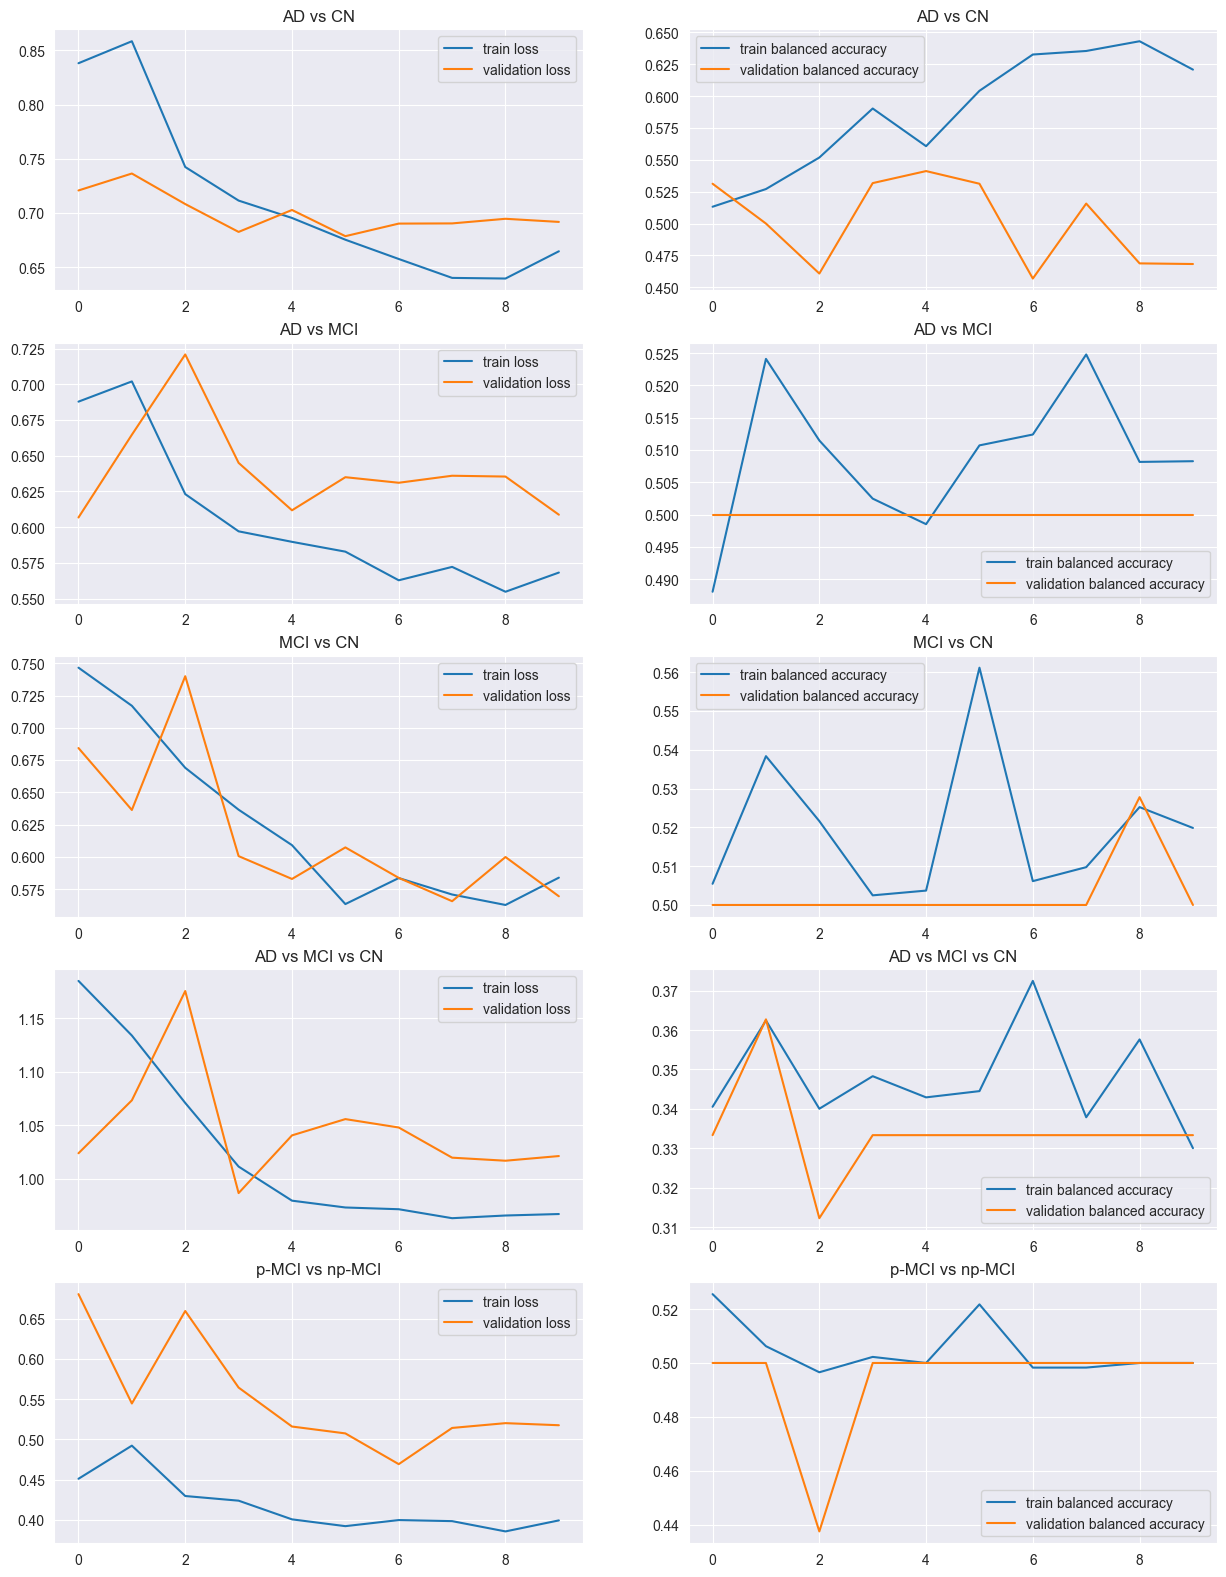

<Figure size 640x480 with 0 Axes>

In [8]:
plt.figure(figsize=(15, 40))
for i, problem in enumerate(problems):
    plt.subplot(10, 2, i*2+1)
    plt.plot(histories[problem]["train_loss"], label="train loss")
    plt.plot(histories[problem]["valid_loss"], label="validation loss")
    plt.title(problem)
    plt.legend()
    plt.subplot(10, 2, i*2+2)
    plt.plot(histories[problem]["train_balanced_accuracy"], label="train balanced accuracy")
    plt.plot(histories[problem]["valid_balanced_accuracy"], label="validation balanced accuracy")
    plt.title(problem)
    plt.legend()
plt.show()
plt.savefig(Path(MODEL_SAVE_DIRECTORY, "training_history.png"))

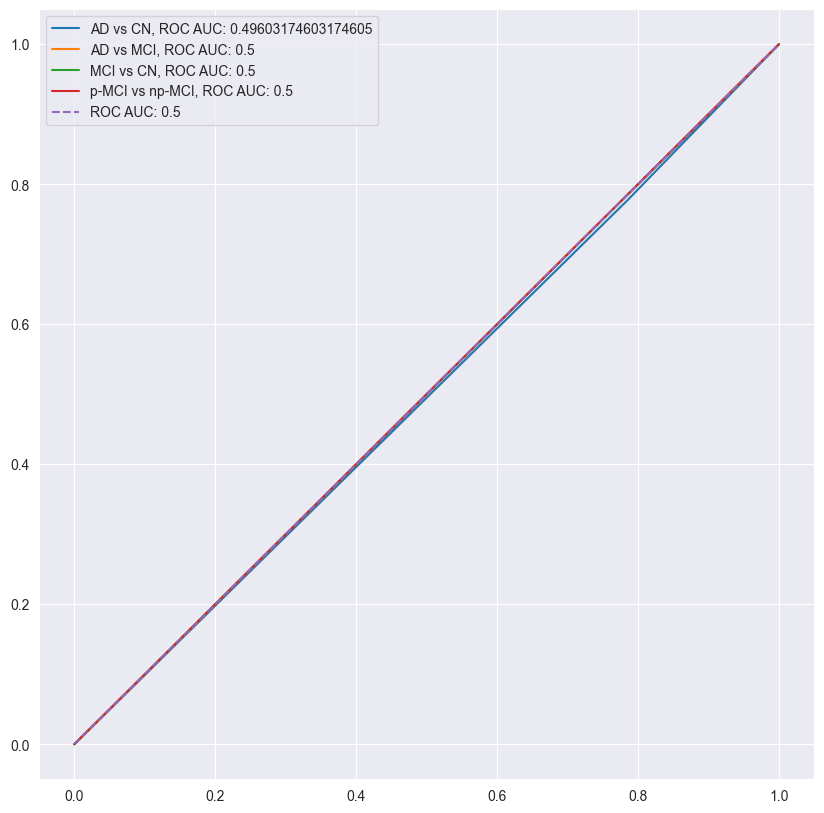

In [9]:
plt.figure(figsize=(10, 10))
for i, problem in enumerate(problems):
    if problem == "AD vs MCI vs CN":
        continue
    curve = results[problem]["test"]["roc_curve"]
    plt.plot(curve[0], curve[1], label=f"{problem}, ROC AUC: {results[problem]['test']['roc_auc']}")
plt.plot([0, 1], [0, 1], linestyle='--', label="ROC AUC: 0.5")
plt.legend()
plt.show()

In [10]:
results_dfs = {problem: pd.DataFrame(results[problem]).drop(["roc_curve", "confusion_matrix"], axis=0, errors="ignore") for problem in problems}

In [11]:
results_dfs["AD vs CN"]

,train,test,valid
accuracy,0.647727,0.53125,0.59375
balanced_accuracy,0.618881,0.496032,0.551587
roc_auc,0.618881,0.496032,0.551587


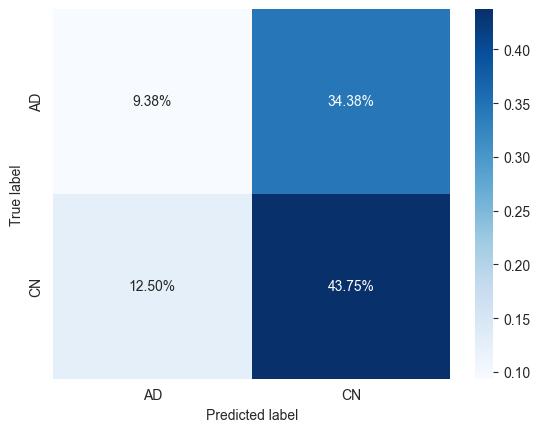

In [12]:
plot_confusion_matrix(results, "AD vs CN", "test")

In [13]:
results_dfs["AD vs MCI"]

,train,test,valid
accuracy,0.734649,0.767857,0.732143
balanced_accuracy,0.5,0.5,0.5
roc_auc,0.5,0.5,0.5


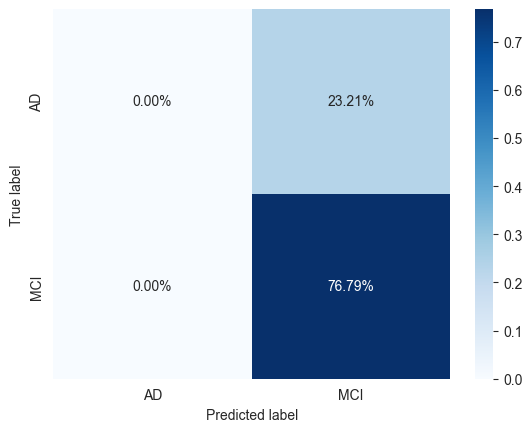

In [14]:
plot_confusion_matrix(results, "AD vs MCI", "test")

In [15]:
results_dfs["MCI vs CN"]

,train,test,valid
accuracy,0.714583,0.733333,0.714286
balanced_accuracy,0.52629,0.5,0.529412
roc_auc,0.52629,0.5,0.529412


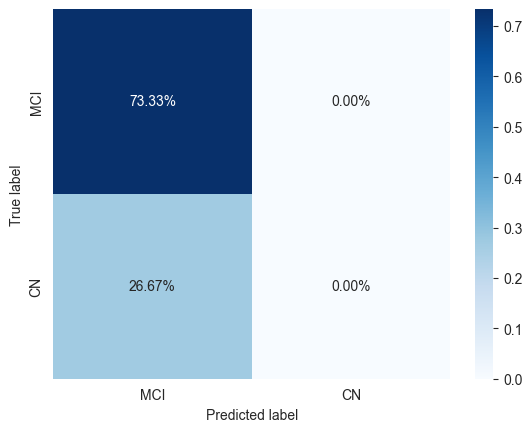

In [16]:
plot_confusion_matrix(results, "MCI vs CN", "test")

In [17]:
results_dfs["AD vs MCI vs CN"]

,train,test,valid
accuracy,0.473333,0.5,0.513889
balanced_accuracy,0.321032,0.330688,0.391667


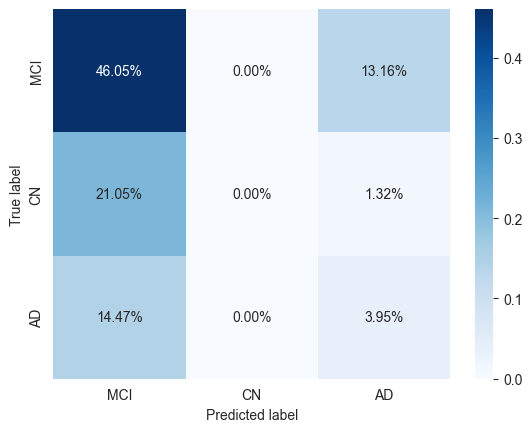

In [18]:
plot_confusion_matrix(results, "AD vs MCI vs CN", "test")

In [19]:
results_dfs["p-MCI vs np-MCI"]

,train,test,valid
accuracy,0.863095,0.909091,0.8
balanced_accuracy,0.5,0.5,0.5
roc_auc,0.5,0.5,0.5


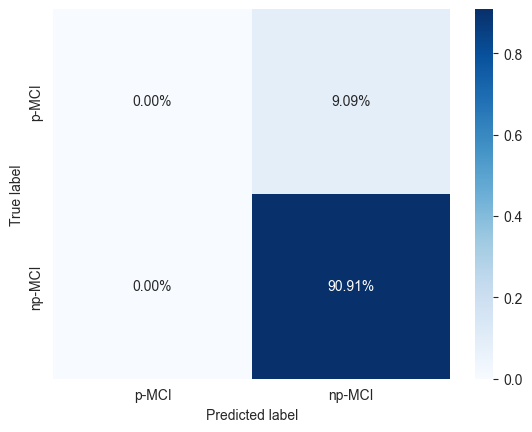

In [20]:
plot_confusion_matrix(results, "p-MCI vs np-MCI", "test")

### Augmentations

/var/folders/16/v2y5n0097wvcclskn_5f_8hm0000gn/T/ipykernel_2025/1243518706.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(4, 4, i+1)


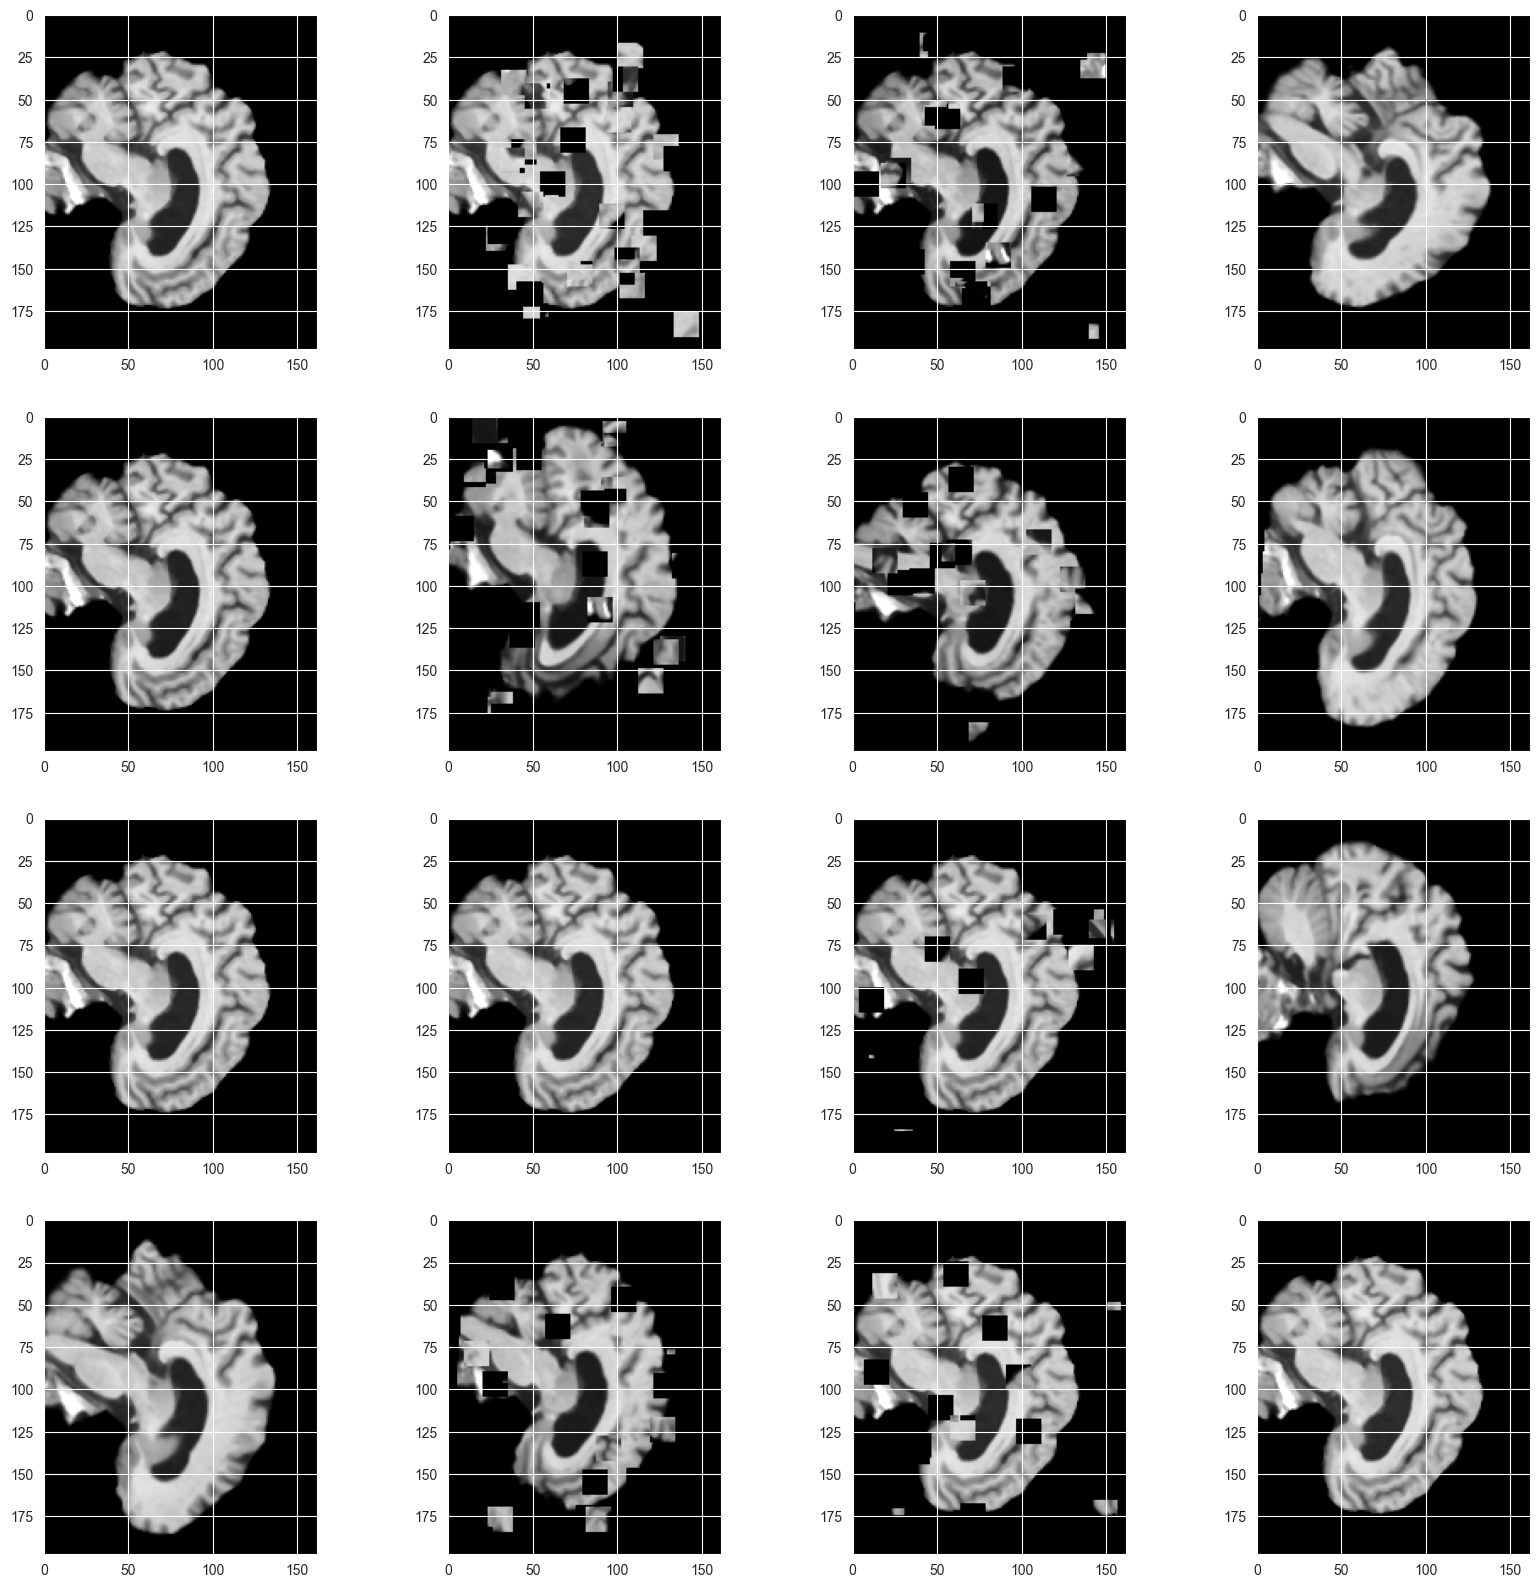

In [21]:
augment_dataloader = Mri3DDataLoader(filter_df_by_problem("AD vs CN", train_df), classification_values=["AD", "CN"], batch_size=batch_size, augment=True)

plt.figure(figsize=(20, 20))
plt.title("Augmented images")
for i in range(16):
    plt.subplot(4, 4, i+1)
    image = augment_dataloader.get_single_item(5)[0].cpu().numpy()
    plt.imshow(image[0,0,70, :, :], cmap="gray")
plt.savefig(Path(MODEL_SAVE_DIRECTORY, "augmentation_sample.png"))
plt.show()

In [22]:
augment_histories = {}
augment_results = {problem: {} for problem in problems}

for problem, columns in problems.items():
    print(f"Training {problem}")
    
    _train_df = Mri3DDataLoader(
        filter_df_by_problem(problem, train_df), 
        classification_values=columns,
        batch_size=batch_size, 
        crop=False, 
        augment=True
    )
    
    _test_df = Mri3DDataLoader(
        filter_df_by_problem(problem, test_df), 
        classification_values=columns,
        batch_size=batch_size, 
        crop=False
    )
    
    _valid_df = Mri3DDataLoader(
        filter_df_by_problem(problem, valid_df), 
        classification_values=columns,
        batch_size=batch_size, 
        crop=False
    )
    
    save_directory = Path(MODEL_SAVE_DIRECTORY, "augmentations", problem)
    
    model = MRINet(num_classes=2 if problem != "AD vs MCI vs CN" else 3)
    model.to("mps")
    
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    history = run_training_loop(
        model=model,
        train_dataset=_train_df,
        valid_dataset=_valid_df,
        num_epochs=num_epochs,
        optimizer=optimizer,
        batch_size=batch_size,
        save_directory=save_directory,
        from_pretrained=False,  # Not using pretrained model
        scheduler=torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1, last_epoch=-1)
    )
    
    augment_histories[problem] = history
    model.load_state_dict(torch.load(Path(save_directory, "best_model.pth")))
    
    augment_results[problem] = {
        "train": evaluate_model(model, _train_df),
        "test": evaluate_model(model, _test_df),
        "valid": evaluate_model(model, _valid_df),
    }
    
    print(augment_results[problem])

Training AD vs CN


Epoch: 0, LR: [0.001] Step loss: 0.856, Step acc: 1.0, Train Accuracy: 0.527, Balanced Accuracy: 0.518, Running Loss: 0.848: 100%|██████████| 66/66 [04:05<00:00,  3.73s/it]
  0%|          | 0/8 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:395: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
Validation Loss - item: 1.913, Validation Accuracy: 0.562, Balanced accuracy: 0.5, Running Loss: 1.643: 100%|██████████| 8/8 [00:03<00:00,  2.10it/s]



Best validation accuracy: 0.5
Saving best model for epoch: 1



Epoch: 1, LR: [0.001] Step loss: 0.821, Step acc: 1.0, Train Accuracy: 0.5, Balanced Accuracy: 0.494, Running Loss: 0.846: 100%|██████████| 66/66 [04:12<00:00,  3.82s/it]  
Validation Loss - item: 1.302, Validation Accuracy: 0.531, Balanced accuracy: 0.5, Running Loss: 1.178: 100%|██████████| 8/8 [00:03<00:00,  2.06it/s]
Epoch: 2, LR: [0.001] Step loss: 0.827, Step acc: 2.0, Train Accuracy: 0.504, Balanced Accuracy: 0.496, Running Loss: 0.756: 100%|██████████| 66/66 [04:44<00:00,  4.31s/it]
Validation Loss - item: 1.122, Validation Accuracy: 0.562, Balanced accuracy: 0.5, Running Loss: 0.86: 100%|██████████| 8/8 [00:04<00:00,  1.80it/s] 
Epoch: 3, LR: [0.0001] Step loss: 0.982, Step acc: 1.0, Train Accuracy: 0.508, Balanced Accuracy: 0.494, Running Loss: 0.721: 100%|██████████| 66/66 [08:05<00:00,  7.36s/it]
Validation Loss - item: 0.754, Validation Accuracy: 0.344, Balanced accuracy: 0.324, Running Loss: 0.825: 100%|██████████| 8/8 [00:10<00:00,  1.30s/it]
Epoch: 4, LR: [0.0001] Step 

{'train': {'accuracy': 0.5416666666666666, 'balanced_accuracy': 0.5, 'roc_auc': 0.5, 'roc_curve': (array([0., 1.]), array([0., 1.]), array([inf,  1.])), 'confusion_matrix': array([[  0, 121],
       [  0, 143]])}, 'test': {'accuracy': 0.5625, 'balanced_accuracy': 0.5, 'roc_auc': 0.5, 'roc_curve': (array([0., 1.]), array([0., 1.]), array([inf,  1.])), 'confusion_matrix': array([[ 0, 14],
       [ 0, 18]])}, 'valid': {'accuracy': 0.5625, 'balanced_accuracy': 0.5, 'roc_auc': 0.5, 'roc_curve': (array([0., 1.]), array([0., 1.]), array([inf,  1.])), 'confusion_matrix': array([[ 0, 14],
       [ 0, 18]])}}
Training AD vs MCI


Epoch: 0, LR: [0.001] Step loss: 1.415, Step acc: 0.0, Train Accuracy: 0.678, Balanced Accuracy: 0.495, Running Loss: 0.685: 100%|██████████| 114/114 [07:21<00:00,  3.87s/it]
Validation Loss - item: 1.895, Validation Accuracy: 0.286, Balanced accuracy: 0.5, Running Loss: 1.397: 100%|██████████| 14/14 [00:06<00:00,  2.05it/s]



Best validation accuracy: 0.5
Saving best model for epoch: 1



Epoch: 1, LR: [0.001] Step loss: 0.655, Step acc: 3.0, Train Accuracy: 0.702, Balanced Accuracy: 0.517, Running Loss: 0.663: 100%|██████████| 114/114 [07:20<00:00,  3.87s/it]
Validation Loss - item: 0.339, Validation Accuracy: 0.714, Balanced accuracy: 0.5, Running Loss: 0.628: 100%|██████████| 14/14 [00:06<00:00,  2.08it/s]
Epoch: 2, LR: [0.001] Step loss: 0.927, Step acc: 3.0, Train Accuracy: 0.711, Balanced Accuracy: 0.504, Running Loss: 0.642: 100%|██████████| 114/114 [07:01<00:00,  3.70s/it]
Validation Loss - item: 1.082, Validation Accuracy: 0.714, Balanced accuracy: 0.5, Running Loss: 0.785: 100%|██████████| 14/14 [00:06<00:00,  2.09it/s]
  0%|          | 0/114 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:395: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
E

{'train': {'accuracy': 0.2741228070175439, 'balanced_accuracy': 0.4980300725631499, 'roc_auc': 0.49803007256314985, 'roc_curve': (array([0.        , 0.03361345, 1.        ]), array([0.        , 0.02967359, 1.        ]), array([inf,  1.,  0.])), 'confusion_matrix': array([[115,   4],
       [327,  10]])}, 'test': {'accuracy': 0.21428571428571427, 'balanced_accuracy': 0.46153846153846156, 'roc_auc': 0.46153846153846156, 'roc_curve': (array([0.        , 0.07692308, 1.        ]), array([0., 0., 1.]), array([inf,  1.,  0.])), 'confusion_matrix': array([[12,  1],
       [43,  0]])}, 'valid': {'accuracy': 0.2857142857142857, 'balanced_accuracy': 0.5, 'roc_auc': 0.5, 'roc_curve': (array([0., 1.]), array([0., 1.]), array([inf,  0.])), 'confusion_matrix': array([[16,  0],
       [40,  0]])}}
Training MCI vs CN


Epoch: 0, LR: [0.001] Step loss: 0.656, Step acc: 2.0, Train Accuracy: 0.635, Balanced Accuracy: 0.489, Running Loss: 0.731: 100%|██████████| 120/120 [07:23<00:00,  3.69s/it]
Validation Loss - item: 0.458, Validation Accuracy: 0.696, Balanced accuracy: 0.5, Running Loss: 0.606: 100%|██████████| 14/14 [00:06<00:00,  2.06it/s]



Best validation accuracy: 0.5
Saving best model for epoch: 1



Epoch: 1, LR: [0.001] Step loss: 0.476, Step acc: 3.0, Train Accuracy: 0.631, Balanced Accuracy: 0.488, Running Loss: 0.686: 100%|██████████| 120/120 [07:22<00:00,  3.69s/it]
  0%|          | 0/14 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:395: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
Validation Loss - item: 0.85, Validation Accuracy: 0.696, Balanced accuracy: 0.5, Running Loss: 0.562: 100%|██████████| 14/14 [00:06<00:00,  2.05it/s] 
Epoch: 2, LR: [0.001] Step loss: 0.452, Step acc: 3.0, Train Accuracy: 0.665, Balanced Accuracy: 0.493, Running Loss: 0.675: 100%|██████████| 120/120 [07:22<00:00,  3.69s/it]
  0%|          | 0/14 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2

{'train': {'accuracy': 0.7020833333333333, 'balanced_accuracy': 0.5034722222222222, 'roc_auc': 0.5034722222222222, 'roc_curve': (array([0., 0., 1.]), array([0.        , 0.00694444, 1.        ]), array([inf,  1.,  0.])), 'confusion_matrix': array([[336,   0],
       [143,   1]])}, 'test': {'accuracy': 0.7166666666666667, 'balanced_accuracy': 0.5, 'roc_auc': 0.5, 'roc_curve': (array([0., 1.]), array([0., 1.]), array([inf,  0.])), 'confusion_matrix': array([[43,  0],
       [17,  0]])}, 'valid': {'accuracy': 0.6785714285714286, 'balanced_accuracy': 0.5, 'roc_auc': 0.5, 'roc_curve': (array([0., 1.]), array([0., 1.]), array([inf,  0.])), 'confusion_matrix': array([[38,  0],
       [18,  0]])}}
Training AD vs MCI vs CN


  0%|          | 0/150 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2466: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
Epoch: 0, LR: [0.001] Step loss: 0.821, Step acc: 3.0, Train Accuracy: 0.493, Balanced Accuracy: 0.343, Running Loss: 1.144: 100%|██████████| 150/150 [20:11<00:00,  8.08s/it]
Validation Loss - item: 1.332, Validation Accuracy: 0.403, Balanced accuracy: 0.4, Running Loss: 1.144: 100%|██████████| 18/18 [00:25<00:00,  1.44s/it]  



Best validation accuracy: 0.3995098039215686
Saving best model for epoch: 1



Epoch: 1, LR: [0.001] Step loss: 1.004, Step acc: 2.0, Train Accuracy: 0.5, Balanced Accuracy: 0.329, Running Loss: 1.069: 100%|██████████| 150/150 [10:10<00:00,  4.07s/it]  
Validation Loss - item: 1.066, Validation Accuracy: 0.528, Balanced accuracy: 0.352, Running Loss: 1.052: 100%|██████████| 18/18 [00:09<00:00,  1.96it/s]
  0%|          | 0/150 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:395: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
Epoch: 2, LR: [0.001] Step loss: 0.68, Step acc: 4.0, Train Accuracy: 1.0, Balanced Accuracy: 1.0, Running Loss: 0.68:   1%|          | 1/150 [00:03<09:46,  3.93s/it]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2466: UserWarning: y_pred contains classes no

{'train': {'accuracy': 0.38666666666666666, 'balanced_accuracy': 0.359694769678403, 'confusion_matrix': array([[137, 201,   0],
       [ 46,  95,   0],
       [ 51,  70,   0]])}, 'test': {'accuracy': 0.34210526315789475, 'balanced_accuracy': 0.3282828282828283, 'confusion_matrix': array([[14, 30,  0],
       [ 6, 12,  0],
       [ 3, 11,  0]])}, 'valid': {'accuracy': 0.4027777777777778, 'balanced_accuracy': 0.388235294117647, 'confusion_matrix': array([[16, 24,  0],
       [ 4, 13,  0],
       [ 7,  8,  0]])}}
Training p-MCI vs np-MCI


Epoch: 0, LR: [0.001] Step loss: 0.019, Step acc: 4.0, Train Accuracy: 0.83, Balanced Accuracy: 0.49, Running Loss: 0.492: 100%|██████████| 84/84 [05:18<00:00,  3.79s/it]  
  0%|          | 0/10 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:395: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
Validation Loss - item: 0.018, Validation Accuracy: 0.8, Balanced accuracy: 0.5, Running Loss: 0.952: 100%|██████████| 10/10 [00:04<00:00,  2.07it/s] 



Best validation accuracy: 0.5
Saving best model for epoch: 1



  0%|          | 0/84 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:395: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
Epoch: 1, LR: [0.001] Step loss: 1.287, Step acc: 2.0, Train Accuracy: 0.851, Balanced Accuracy: 0.521, Running Loss: 0.515: 100%|██████████| 84/84 [05:18<00:00,  3.79s/it]
Validation Loss - item: 0.15, Validation Accuracy: 0.8, Balanced accuracy: 0.5, Running Loss: 0.65: 100%|██████████| 10/10 [00:04<00:00,  2.10it/s]   
Epoch: 2, LR: [0.001] Step loss: 0.152, Step acc: 4.0, Train Accuracy: 0.833, Balanced Accuracy: 0.501, Running Loss: 0.469: 100%|██████████| 84/84 [38:57<00:00, 27.82s/it]   
Validation Loss - item: 0.192, Validation Accuracy: 0.825, Balanced accuracy: 0.5, Running Loss: 0.47: 100%|██████████| 10/10 [00:04<00:00,  2.03it/s]
Epoch

{'train': {'accuracy': 0.8630952380952381, 'balanced_accuracy': 0.5, 'roc_auc': 0.5, 'roc_curve': (array([0., 1.]), array([0., 1.]), array([inf,  1.])), 'confusion_matrix': array([[  0,  46],
       [  0, 290]])}, 'test': {'accuracy': 0.9090909090909091, 'balanced_accuracy': 0.5, 'roc_auc': 0.5, 'roc_curve': (array([0., 1.]), array([0., 1.]), array([inf,  1.])), 'confusion_matrix': array([[ 0,  4],
       [ 0, 40]])}, 'valid': {'accuracy': 0.8, 'balanced_accuracy': 0.5, 'roc_auc': 0.5, 'roc_curve': (array([0., 1.]), array([0., 1.]), array([inf,  1.])), 'confusion_matrix': array([[ 0,  8],
       [ 0, 32]])}}


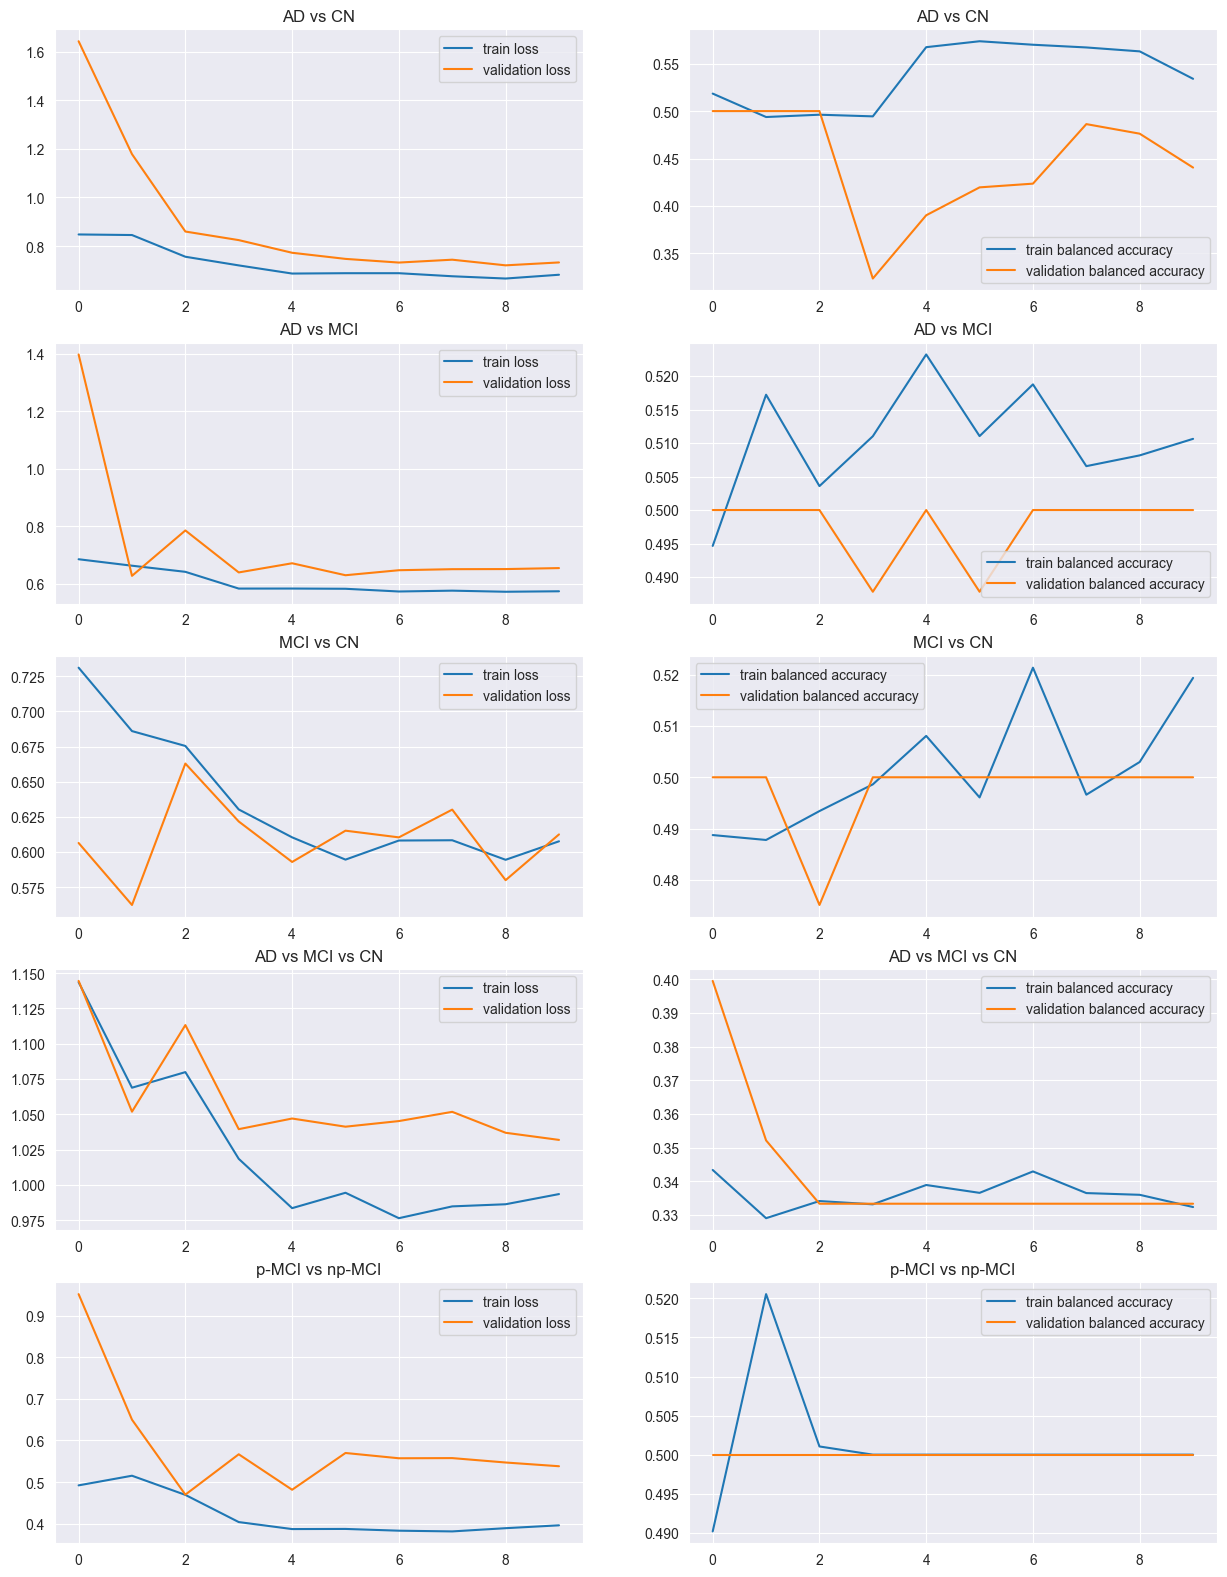

<Figure size 640x480 with 0 Axes>

In [23]:
plt.figure(figsize=(15, 40))
for i, problem in enumerate(problems):
    plt.subplot(10, 2, i*2+1)
    plt.plot(augment_histories[problem]["train_loss"], label="train loss")
    plt.plot(augment_histories[problem]["valid_loss"], label="validation loss")
    plt.title(problem)
    plt.legend()
    plt.subplot(10, 2, i*2+2)
    plt.plot(augment_histories[problem]["train_balanced_accuracy"], label="train balanced accuracy")
    plt.plot(augment_histories[problem]["valid_balanced_accuracy"], label="validation balanced accuracy")
    plt.title(problem)
    plt.legend()
plt.show()
plt.savefig(Path(MODEL_SAVE_DIRECTORY, "training_history_augmentation.png"))

In [24]:
results_dfs = {problem: pd.DataFrame(augment_results[problem]).drop(["roc_curve", "confusion_matrix"], axis=0, errors="ignore") for problem in problems}

In [25]:
results_dfs["AD vs CN"]

,train,test,valid
accuracy,0.541667,0.5625,0.5625
balanced_accuracy,0.5,0.5,0.5
roc_auc,0.5,0.5,0.5


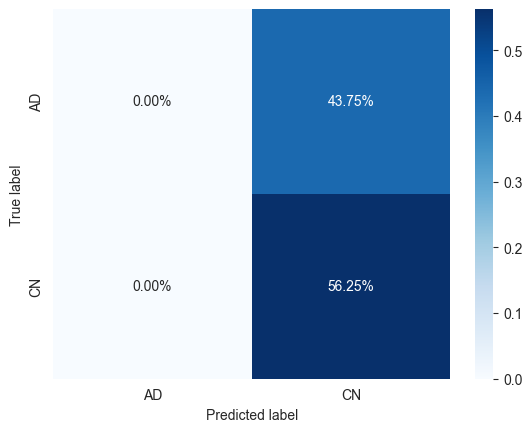

In [26]:
plot_confusion_matrix(augment_results, "AD vs CN", "test")

In [27]:
results_dfs["AD vs MCI"]

,train,test,valid
accuracy,0.274123,0.214286,0.285714
balanced_accuracy,0.49803,0.461538,0.5
roc_auc,0.49803,0.461538,0.5


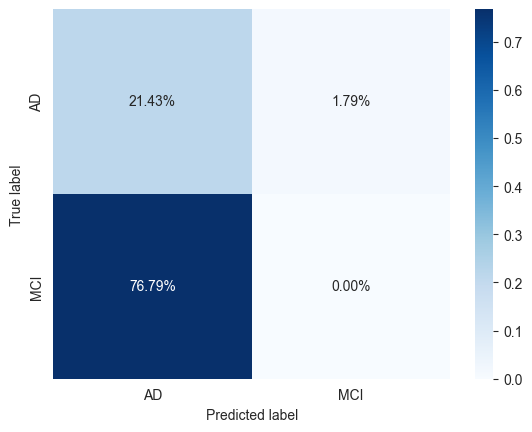

In [28]:
plot_confusion_matrix(augment_results, "AD vs MCI", "test")

In [29]:
results_dfs["MCI vs CN"]

,train,test,valid
accuracy,0.702083,0.716667,0.678571
balanced_accuracy,0.503472,0.5,0.5
roc_auc,0.503472,0.5,0.5


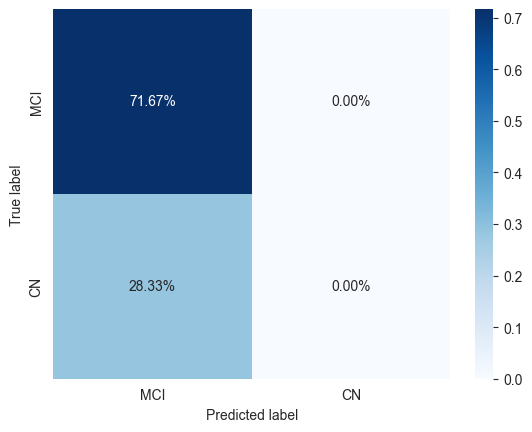

In [30]:
plot_confusion_matrix(augment_results, "MCI vs CN", "test")

In [31]:
results_dfs["AD vs MCI vs CN"]

,train,test,valid
accuracy,0.386667,0.342105,0.402778
balanced_accuracy,0.359695,0.328283,0.388235


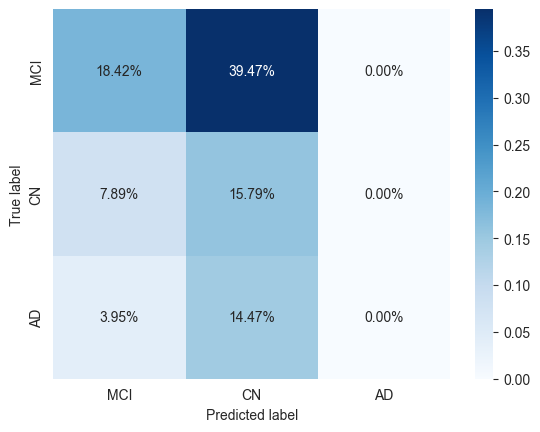

In [32]:
plot_confusion_matrix(augment_results, "AD vs MCI vs CN", "test")

In [33]:
results_dfs["p-MCI vs np-MCI"]

,train,test,valid
accuracy,0.863095,0.909091,0.8
balanced_accuracy,0.5,0.5,0.5
roc_auc,0.5,0.5,0.5


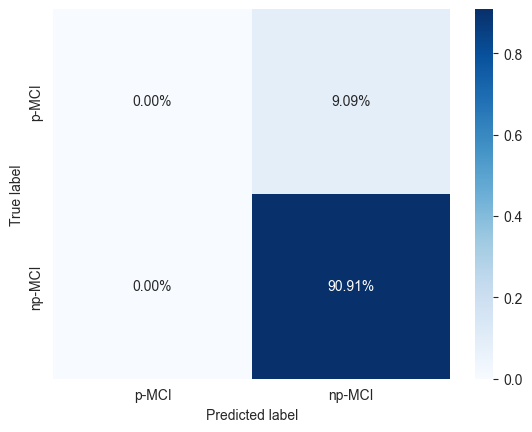

In [34]:
plot_confusion_matrix(augment_results, "p-MCI vs np-MCI", "test")